# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
X = boston["data"]
y = boston["target"]

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.89005311713829

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ### your code here
    N = len(y)
    OOB= pd.DataFrame() #  матрица принадлежности i-го объекта j-той выборке
    Predicts = pd.DataFrame() # матрица предсказаций на i-том объекте j-того алгоритма
    for j in range(num_runs):
        bts = np.random.choice(N, N, replace=True) 
        OOB[j] = np.array([True] * N) 
        OOB[j][bts] = False
        regressor.fit(X[bts], y[bts])
        Predicts[j] = np.array([0] * N)
        Predicts[j][OOB[j]] = regressor.predict(X[OOB[j]]) #  0, если объект не входил в OOB для j-той выборки
    
    idx = np.array(range(N)) # индексы 
    E_X = np.mean(Predicts.loc[idx][OOB.loc[idx]], axis=1) #средние ответы для объектов по тем моделям, где они в OOB
    bias = np.mean((E_X - y[idx])**2) 
    variance = np.mean(np.mean((Predicts.loc[idx][OOB.loc[idx]] - np.tile(E_X, (num_runs, 1)).T)**2))
    Error = (Predicts - np.tile(y, (num_runs, 1)).T) ** 2 # матрица квадратных ошибок
    L = np.mean(np.mean(Error[OOB], axis=1))
    return bias, variance, L

## __2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
lm = compute_biase_variance(LinearRegression(), X, y)

In [45]:
dt = compute_biase_variance(DecisionTreeRegressor(), X, y)

In [48]:
rf = compute_biase_variance(RandomForestRegressor(), X, y)

In [49]:
ans = pd.DataFrame()
ans['lm'] = np.array(lm)
ans['dt'] = np.array(dt)
ans['rf'] = np.array(rf)
ans = ans.T
ans.columns = ['bias', 'var', 'L']
ans

,bias,var,L
lm,23.899611,0.977944,24.878480
dt,10.244124,13.398008,23.693499
rf,10.826699,2.325883,13.167341


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ вроде согласуются.

Ну для линейной модели все норм. У них большое смещение (так как линейная модель - отстояная модель), но разброс небольшой, так как наилучшую линию все равно сложно провести по разному, даже меняя выборки достаточно сильно. Тут все согласуется.

Обычное дерево тоже похоже. Смещение у него уже лучше, так как дерево под данные подгоняется лучше, но зато меняя немного выборку, мы можем получить достаточно сильно изменение в структуре дерева. Ну то есть разброс растет. Ну и в итоге ошибка такая же.

Теперьь к лесу. Я так и не дождался выполнения леса с дефолтными настройками, поэтому его немного зарегуляризовал. Ну я это учту. Разброс у леса, как и следовало оживать, очень низний. Потому что, во-первых, я ограничил глубину дерева, а значит скорее всего все деревья находят примерное одинаковые сильные признаки. Поэтому они похожи и разброс маленький. А, во-вторых, деревьев много, поэтому, мы скорее не переобучимся. То есть, меняя выборку, мы получаем те же результаты, что и были. Потому что если даже какое-то дерево переобучится на какой-то объект, то другие нет и все сгладится. Смещение тоже низкое. Чуть выше, чем у обычного дерева, ну сори, я достаточно сильно зарегуляризовал, на глубине 5 деревья явно недообучаются.

In [9]:
# Bagging of linear models
compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)

(24.019457898234702, 1.0991633913411634, 25.12167352365734)

In [10]:
# Bagging of decision trees
compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)

(10.948825754149572, 3.4992177652733436, 14.457328604336317)

In [22]:
# Bagging of bagging of trees (of random forest)
compute_biase_variance(BaggingRegressor(RandomForestRegressor(), n_jobs=-1), X, y)

(11.947502931238754, 1.4621591824158182, 13.408378017801677)

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В теории беггинг уменьшает разброс можели в n раз, но это при условии того, что ошибки моделей не скоррелированы. Это очев не так. Особенно это не так для леса, который сам по себе является беггингом над деревьями, тут уже нечего беггить. 

Беггинг над деревьями - это и есть случайный лес (правда в дефолтном лесу 100 деревьев, а в беггинге 10 базовых моделей). Поэтому беггинг над деревьями дал такое же смещение, что и лес, еще уменьшил разброс в 5 раз (при некоррелированых ошибках должен был бы в 10), но ошибка у леса все таки меньше (ну логично, там 100 деревьев). Крч тут да, сильно помог.

Беггинг над линейными моделями особо изменений не дал (в пределах погрешности). Это потому, что некоррелированность ошибки ну никак не выполняется, наоборот, проводя линию примерно одинакого, ошибка будет примерно хорошо скоррелированной. Ну и потому что линейная комбинация линейных моделей это, конечно, кайф.

Беггинг над лесом. Но уже видно, что разброс немного уменьшился (не в 10 раз, по тем же причинам), а смещение немного выросло. Так что тут беггинг не особо помог, смещение хз, почему выросло (наверное потому что это семейство моделей и так выжимает минимальную ошибку), а разброс уменьшился, потому что по сути в 10 раз увеличили кол-во деревьев.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [9]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    
    """
    plot graphics described above
    """
    test_objects = np.random.choice(X.shape[0], num_test_objects, replace=False) 
    X_train = np.delete(X, test_objects, axis=0)
    y_train = np.delete(y, test_objects)
    X_test = X[test_objects]
    y_test = y[test_objects]
    
    N = len(y_train)
    OOB = pd.DataFrame() #  матрица принадлежности i-го объекта j-той выборке
    Predicts = pd.DataFrame() # матрица предсказаций на i-том объекте j-того алгоритма
    for j in range(num_runs):
        bts = np.random.choice(N, N, replace=True) 
        #OOB[j] = np.array([True] * N) 
        #OOB[j][bts] = False
        regressor.fit(X_train[bts], y_train[bts])
        #Predicts[j] = np.array([0] * N)
        #Predicts[j][OOB[j]] = regressor.predict(X_train[OOB[j]]) #  0, если объект не входил в OOB для j-той выборки
        Predicts[j] = regressor.predict(X_test)
    
    yy = np.array(Predicts).flatten('C')
    xx = np.repeat(np.arange(num_test_objects), num_runs)

    if ax == None:
        plt.figure(figsize=(10,10))
        plt.title(title)
        plt.xlabel('test objects')
        plt.ylabel('predictions')
        plt.scatter(x=xx, y=yy, c='pink')
        plt.scatter(x=np.arange(num_test_objects), y=y_test, c='black')
    else:
        ax.set_xlabel('test objects')
        ax.set_ylabel('predictions')
        ax.set_title(title)
        ax.scatter(x=xx, y=yy, c='pink')
        ax.scatter(x=np.arange(num_test_objects), y=y_test, c='black')


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

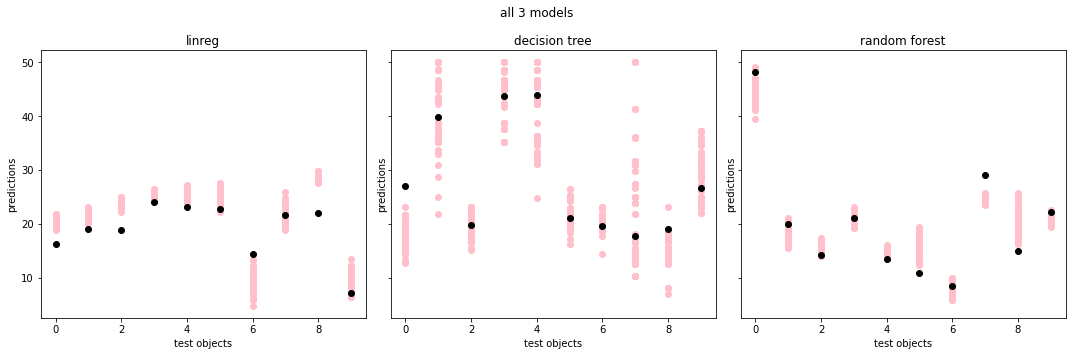

In [129]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plot_predictions(LinearRegression(), X, y, ax=ax1, title='linreg')
plot_predictions(DecisionTreeRegressor(), X, y, ax=ax2, title='decision tree')
plot_predictions(RandomForestRegressor(), X, y, ax=ax3, title='random forest')
fig.suptitle('all 3 models')
fig.tight_layout()
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Ну поехали. 

Из результатов мы помним, что у линейных моделей маленький разброс, но большое смещение, вся ошибка в основном из-за второго. Ну это видно - сосиски у нас кототкие, это значит, что точки особо не разбросаны и лежат плотненько. Это и значит маленький разброс. Но вот зато правильный ответ - черная точка - частенько лежит не то, чтобы не в центре, а на краю или вообще за сосиской. Это и значит большое смешение - мы промахиваемся средним ответом.

На втором графике дерево. У дерева большой разброс, это и видно: для всех 10 объектов сосиски очень длинные. Это значит, что ответы моделей сильно зависят от выборки. Зато черные точки частенько лежат близко к центру сосисок, хотя иногда и вылетают. Поэтому смещение тут небольшое, а вот разброс побольше будет. Крч все согласуется с резульатами.

Лес. Ну тут сосиски еще короче в среднем, чем у линейным моделей, это означает маленький разброс, ну так оно и есть.
Так же можно видеть, что часто правильные ответы лежат близео к центру сосисок. Глазов это, конечно, плохо видно, но в целом, все равно заметно, что ситуация со смещением лучше, чем у линейных моделей. Ну и это правда так. Хотя численно там лучше в 2 раза, а из картинки это плохо видно.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [10]:
bias_of_md = []
var_of_md = []
for md in range(1, 11):
    b, v, l = compute_biase_variance(DecisionTreeRegressor(max_depth=md), X, y)
    bias_of_md.append(b)
    var_of_md.append(v)
    
bias_of_mf = []
var_of_mf = []
for mf in range(1, X.shape[1] + 1):
    b, v, l = compute_biase_variance(DecisionTreeRegressor(max_features=mf), X, y)
    bias_of_mf.append(b)
    var_of_mf.append(v)

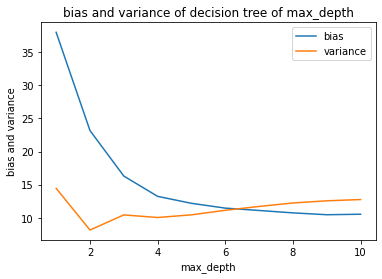

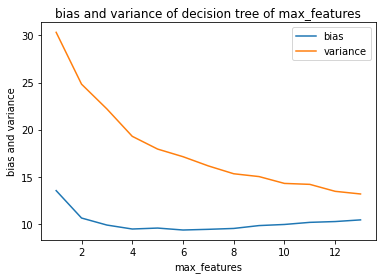

In [14]:
#plt.figure(figsize=())
plt.plot(range(1, 11), bias_of_md, label='bias')
plt.plot(range(1, 11), var_of_md, label='variance')
plt.title('bias and variance of decision tree of max_depth')
plt.xlabel('max_depth')
plt.ylabel('bias and variance')
plt.legend()
plt.show()

plt.plot(range(1, X.shape[1] + 1), bias_of_mf, label='bias')
plt.plot(range(1, X.shape[1] + 1), var_of_mf, label='variance')
plt.title('bias and variance of decision tree of max_features')
plt.xlabel('max_features')
plt.ylabel('bias and variance')
plt.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга: тут все равно не дают баллов за графики, поэтому построю не на дефолтных настройках, все равно разница небольшой будет

In [15]:
bias_of_n_rf = []
var_of_n_rf = []
for n in 2 ** np.arange(1, 10):
    b, v, l = compute_biase_variance(RandomForestRegressor(n_estimators=n, n_jobs=-1), X, y, num_runs=100)
    bias_of_n_rf.append(b)
    var_of_n_rf.append(v)

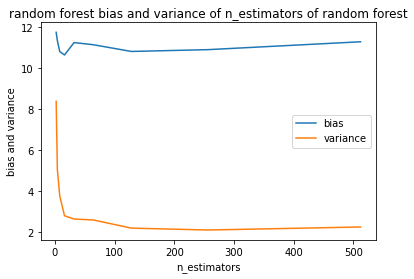

In [16]:
plt.plot((2 ** np.arange(1, 10)), bias_of_n_rf, label='bias')
plt.plot(2 ** np.arange(1, 10), var_of_n_rf, label='variance')
plt.title('random forest bias and variance of n_estimators of random forest')
plt.xlabel('n_estimators')
plt.ylabel('bias and variance')
plt.legend()
plt.show()

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
bias_of_n_gb = []
var_of_n_gb = []
for n in 2 ** np.arange(1, 10):
    b, v, l = compute_biase_variance(GradientBoostingRegressor(n_estimators=n), X, y, num_runs=100)
    bias_of_n_gb.append(b)
    var_of_n_gb.append(v)

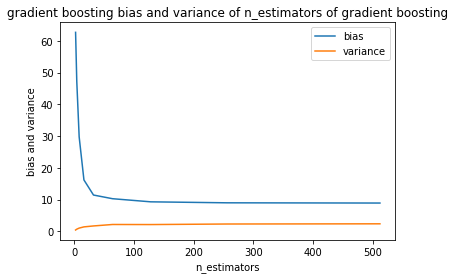

In [18]:
plt.plot(2 ** np.arange(1, 10), bias_of_n_gb, label='bias')
plt.plot(2 ** np.arange(1, 10), var_of_n_gb, label='variance')
plt.title('gradient boosting bias and variance of n_estimators of gradient boosting')
plt.xlabel('n_estimators')
plt.ylabel('bias and variance')
plt.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ Пойдем по порядку.

1) Разброс и смещение дерева в зависимости от глубины.
Ну видно, что смещение монотонно убывает все медленней. Это логично. Неглубокие деревья недообучены. Поэтому, увеличивая глубину, мы позволяем дереву обучиться все лучше, соответственно, уменьшая смещение (среднее непопадание). Ну и ясно, что сначала это прям сильно помогает, но каждая следующая итерация уже менее важна, потому что разделение на 1 шаг дальше дальше не дает значимого улучшения (самое важные признаки уже использовали). Поэтому и получается такая гиперболка.
Что касается разброса, то тут тоже все согласуется с теорией. Первые 2 шага у нас он падает, потому что деревья глубины 2 ну прям совсем отстойные и недообученные, а дальше он начинает монотонно расти, потому что деревья начинают переобучаться. Ну и типо, меняя выборку, мы уже достаточно сильно меняем структуру дерева. И чем глубже, тем это заметнее.

2) Разброс и смещение дерева в зависимости от max features.
Ну разброс объясняется легко. Здесь монотонно убывание со снижающимися темпами. Логика простая: когда у нас дается мало признаков на вершину, по котором можно разбивать, 2 построенных дерева могут получить вообще разное подмножество признаков, ну и ясно, что их структура будет кардинально различаться. Ну и поэтому они будут очень чувствительны к выборкам. Это и есть большой разброс. Когда мы им разрешаем использовать почти все признаки, структуры деревьем уже будут очень похожи, это и значит небольшой разброс. Со смещением сложнее. В начале оно убывает - это ясно, так как мы разрешаем дереву все лучше обучаться, поэтому оно получается лучше в плане угадываний в среднем (смещение до какого-то момента убывает). Потом, видимо, остаются только какие-то мусорные признаки, из-за которых смещение дерева, хоть и не сильно, но почему-то начинает расти. Хотя, казалось бы, не нравятся признаки - не используй. А, ну я понял, почему это так. Дерево просто переобучается, поэтому смещение начинает расти.

3) Разброс и смещение леса в зависимости от количества деревьев.
Со смещением все ясно. Оно сначала резко падает, а дальше выходит на плато и особо не меняется. Это потому, что сначала лес недообучается (все таки деревья в нем зарегуляризованы), а потом ему становится норм. Ну и т.к. он не переобучается, смещение особо не меняется дальше. Разброс тоже объясним: Он сначала резко падает (потому что когда мало деревьев, их "совокупные структуры" отличаются заметно, по сути это все еще не лес, а несколько деревьев, соответственно лес еще чувствителен к выборке. И так до какого-то момента происходит. Далее график выходит на плато и все. Ну там просто лес уже нормальным становится, увеличение количества деревьев уже бесполезно, так как их и так достаточно много.

4) Разброс и смещение бустинга в зависимости от количества деревьев.
Тут логика очень похожа. В начале бустинг похож на несколько простых деревьев, поэтому идет ощутимое падение смещения и неощутимый рост разброса. Потом бустинг начинает работать норм. И при увеличении количества деревьем смещение не уменьшается, так как всю информацию бустинг уже достал, а разброс не увеличивается, потому что это бустинг, его сложно переобучить. Ну типо деревьев так много, что переобучения нет. Ну отличие тут только в том, что в начале разброс растет. Ну потому что в лесу просто идет по сути несколько деревьев, а в бустинге деревья идут по очереди, поэтому увеличение их количества - усложнение структуры композиции -> чувствительность к выборке -> увеличение разброса.